# Cifar-10 이미지 분류 v1
- 참고: https://gruuuuu.github.io/machine-learning/cifar10-cnn/, https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer

In [1]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
X_train.shape, X_test.shape, y_train.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1))

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

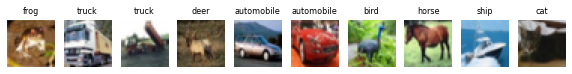

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i]), plt.axis('off')
    plt.title(class_names[y_train[i,0]], fontsize=8)
plt.show()

In [6]:
# X data: 0~1 사이의 실수(float32)로 변환
X_train = X_train.astype('float32') / 255.      # default는 64: 0이라는 값을 갖기 위해 64bit가 필요함 => 비효율적이므로, 32bit로 설정한다. 
X_test = X_test.astype(np.float32) / 255.       # 0 ~ 255 => 0 ~ 1 사이의 값일 때 최적의 성능을 구할 수 있다. 

In [7]:
# y_data: one-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test) 

- 모델 정의/설정/학습/평가
    - Dense층에 전달한 매개변수는 은닉 유닛의 개수이고, 하나의 은닉 층은 층이 나타내는 표현 공간에서 하나의 차원이 된다.
    - 은닉 유닛이 만약 16개가 있다면, 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻
    - 입력 데이터와 W를 dot product하면 입력 데이터가 16차원으로 표현된 공간으로 투영된다.
        - 편향 벡터 b를 더하고 relu 연산을 적용한다.
    - 표현 공간의 차원을 `신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도`
    - 은닉 유닛을 늘리면(표현 공간을 더 고차원으로 만들면) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원하지 않는 패턴을 학습할 수도 있다
        - 훈련 데이터에서는 성능이 향상되지만 테스트 데이터에는 그렇지 않은 패턴
    - Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있다. 
        - 즉, 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 한다.
    - 한 층이 분류 문제에 필요한 정보를 누락하면 그 다음 층에서 이를 복원할 수 없다.
        - 각 층은 잠재적으로 정보의 병목이 될 수 있다.
<br></br>
    - `softmax`: 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 사용
        - ex. Dense(46, activation='softmax')라면, 46차원의 출력 벡터를 만들며, output[i]는 어떤 샘플이 i에 속할 확률 => 46개의 값을 더하면 1이 된다.
<br></br>
    - `categorical_crossentropy`: 두 확률분포 사이의 거리를 측정한다. 
        - 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리
        - 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 된다. 

In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [9]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3) ,activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [10]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model_path = 'best-cifar10-v1.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

In [12]:
# model.fit() 메서드는 History 객체를 반환하고, 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있다. 
hist = model.fit(X_train, Y_train, validation_split=0.2,
                epochs=100, batch_size=32, verbose=2,
                 callbacks=[checkpoint, early_stop]                 
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.57289, saving model to best-cifar10-v1.h5
1250/1250 - 32s - loss: 1.8282 - accuracy: 0.3282 - val_loss: 1.5729 - val_accuracy: 0.4281 - 32s/epoch - 26ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 1.57289 to 1.38318, saving model to best-cifar10-v1.h5
1250/1250 - 20s - loss: 1.5207 - accuracy: 0.4437 - val_loss: 1.3832 - val_accuracy: 0.5029 - 20s/epoch - 16ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 1.38318 to 1.27437, saving model to best-cifar10-v1.h5
1250/1250 - 21s - loss: 1.3958 - accuracy: 0.4930 - val_loss: 1.2744 - val_accuracy: 0.5531 - 21s/epoch - 17ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 1.27437 to 1.24583, saving model to best-cifar10-v1.h5
1250/1250 - 22s - loss: 1.3004 - accuracy: 0.5329 - val_loss: 1.2458 - val_accuracy: 0.5537 - 22s/epoch - 17ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 1.24583 to 1.19537, saving model to best-cifar10-v1.h5
1250/1250 - 23s - lo

In [13]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.6661 - accuracy: 0.7800


[0.6660532355308533, 0.7799999713897705]

- 학습과정 시각화

In [14]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

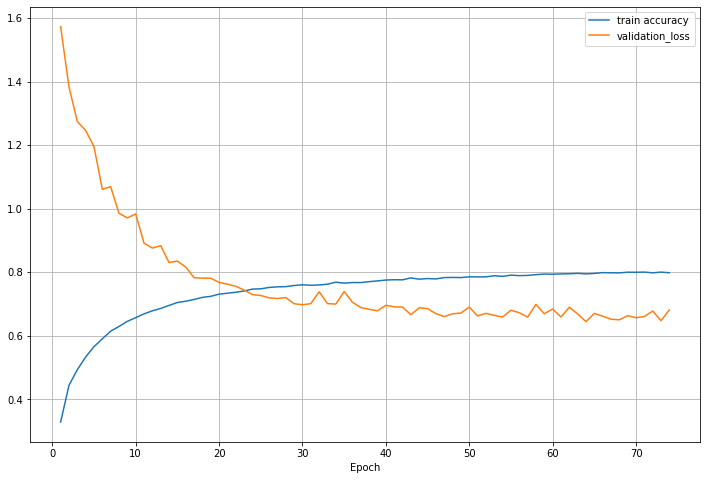

In [15]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation_loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()